In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
)


In [2]:
X = pd.read_csv("../data/train_values.csv")
y = pd.read_csv("../data/train_labels.csv")
y = y.set_index("building_id")
X = X.set_index("building_id")


sns.set_theme()

In [3]:
from dmgpred.cleaning import clean

X = clean(X)[0]

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260601 entries, 802906 to 747594
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  category
 1   geo_level_2_id                          260601 non-null  category
 2   geo_level_3_id                          260601 non-null  category
 3   age                                     260601 non-null  int64   
 4   area_percentage                         260601 non-null  int64   
 5   height_percentage                       260601 non-null  int64   
 6   land_surface_condition                  260601 non-null  category
 7   foundation_type                         260601 non-null  category
 8   roof_type                               260601 non-null  category
 9   ground_floor_type                       260601 non-null  category
 10  other_floor_type                

When looking at the categoricals there are different groups. There are the 3 geo_ids that have been converted to categoricals. There is count_families which has also been conveerted to categorical with the three groups 0,1,2+ (ordinal). And there are the categories legal_ownership_status, land_surface_condition foundation_type, roof_type, ground_floor_type, other_floor_type, position, plan_configuration that were categorical from the beginning.

In [5]:
cat_cols = cat_cols = X.select_dtypes(include="category").columns
id_cols = [col for col in X.columns if col.endswith("id")]
cat_cols = [col for col in cat_cols if col not in id_cols]
cat_cols.remove("count_families")

To start with, I will only look at the initial categorical columns and not at geo_ids and count_families. 

In [6]:
X[id_cols] = X[id_cols].astype("int")
X_fam_encoded = OrdinalEncoder().fit_transform([X["count_families"]])
X["count_families"] = X_fam_encoded[0]

### Category Encoders

currently: one-hot encoder for categories except ordinal encoder for count_families

In [55]:
def __plot_cat_encoder_importances(encoder, X, y):
    X_cat_encoded = encoder.fit_transform(X[cat_cols])
    if isinstance(X_cat_encoded, pd.DataFrame):
        X_cat_encoded_df = X_cat_encoded
    else:
        X_cat_encoded_df = pd.DataFrame(
            X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols)
        )
    X_copy = X.copy
    X = X.drop(cat_cols, axis=1)
    X[X_cat_encoded_df.columns] = X_cat_encoded_df
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
    )
    normalize_cols = ["area_percentage", "height_percentage"]
    normalizer = PowerTransformer("yeo-johnson").fit(X_train[normalize_cols])
    X_train[normalize_cols] = normalizer.transform(X_train[normalize_cols])
    X_test[normalize_cols] = normalizer.transform(X_test[normalize_cols])
    rf = RandomForestClassifier(n_estimators=50, max_depth=3)
    rf.fit(X_train, y_train)
    print(rf.score(X_test, y_test))
    feature_names = rf.feature_names_in_
    importances = rf.feature_importances_
    importances = pd.Series(importances, index=feature_names).sort_values(
        ascending=True
    )
    importances.plot.barh(figsize=(10, 10))
    plt.title("Overview of all feature importances")
    plt.show()
    importances[encoder.get_feature_names_out(cat_cols)].plot.barh(figsize=(10, 5))
    plt.title("Overview of categorical feature importances")
    plt.show()
    X = X_copy

/home/i40/dbkurs13/task-1-earthquake-damage-prediction/venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5689091495142055


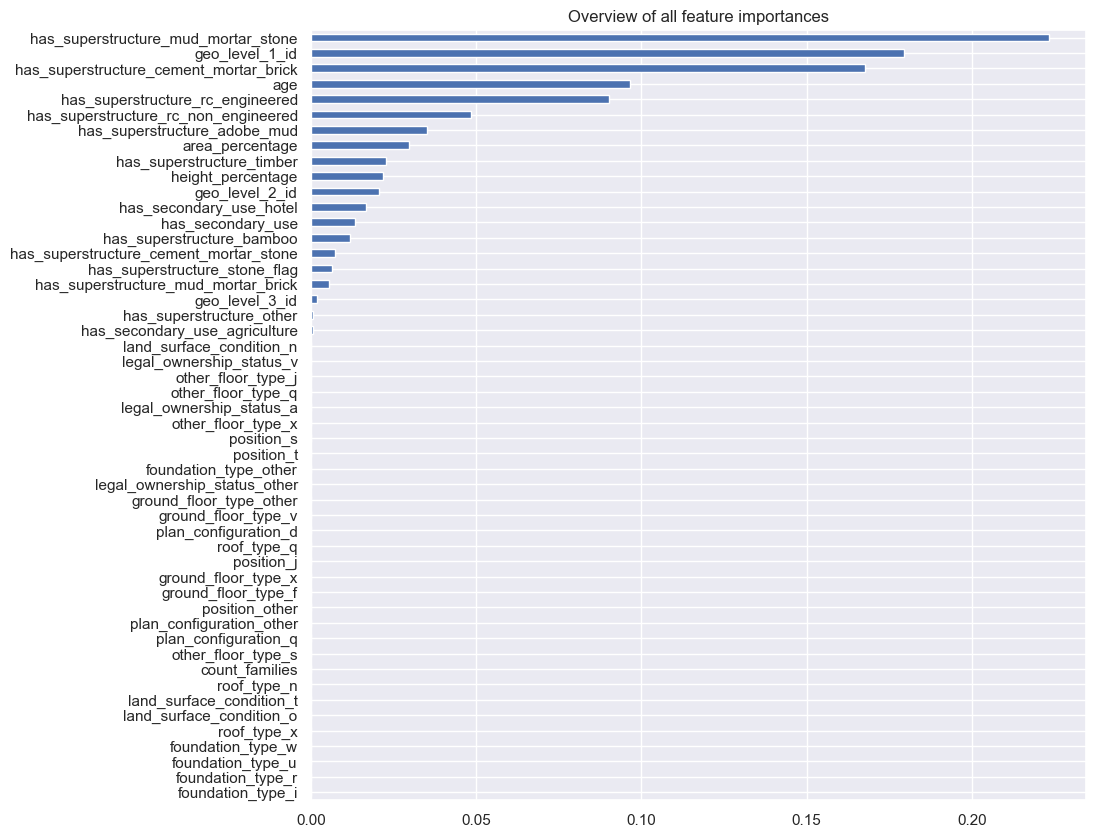

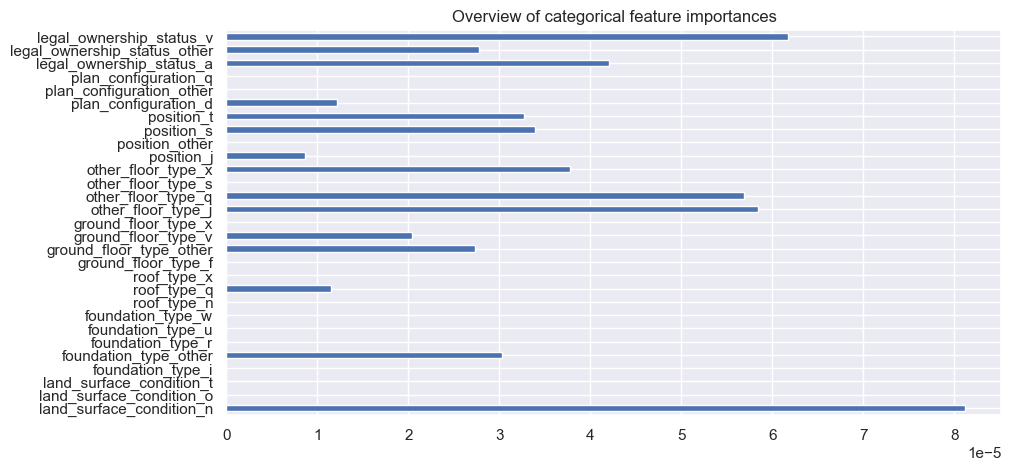

In [56]:
oh_encoder = OneHotEncoder()
__plot_cat_encoder_importances(oh_encoder, X, y)

It can be seen that with the current encoding the categeorical values have an extremely low importance.

### Backward Difference Constrast Encoder

/home/i40/dbkurs13/task-1-earthquake-damage-prediction/venv/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/i40/dbkurs13/task-1-earthquake-damage-prediction/venv/lib/python3.10/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/home/i40/dbkurs13/task-1-earthquake-damage-prediction/venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5752175714877745


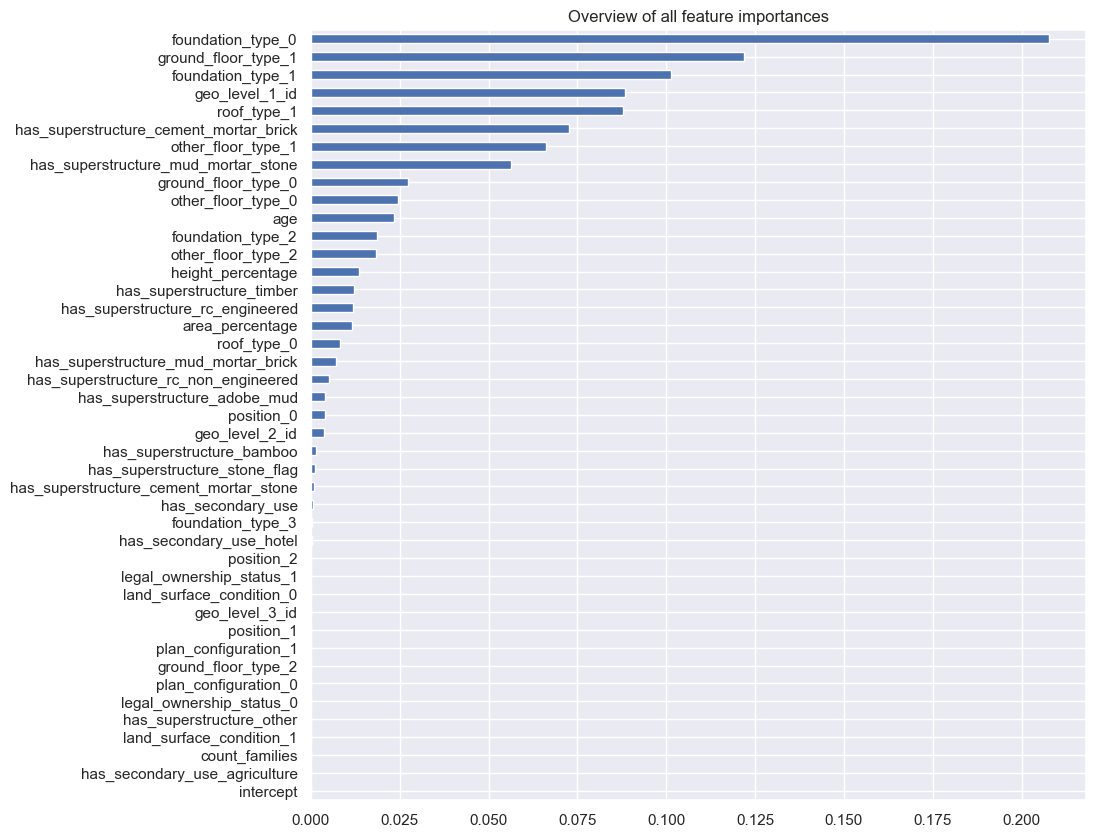

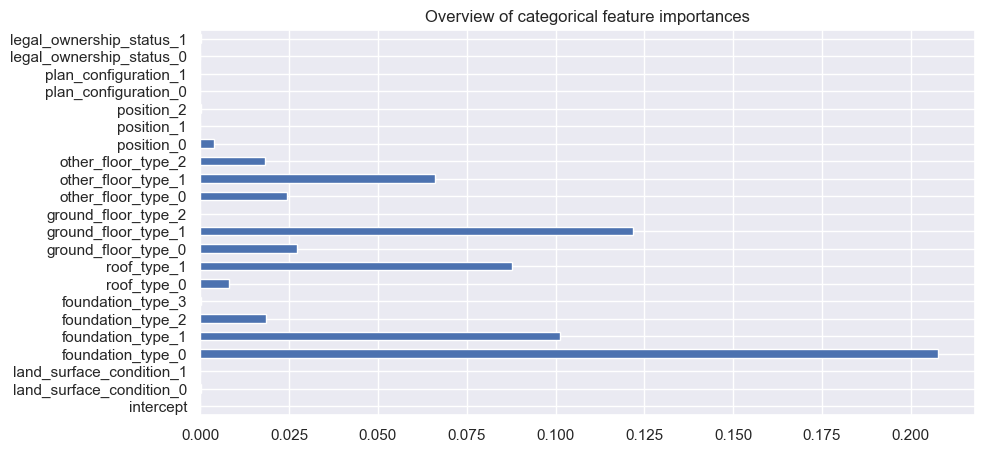

In [57]:
bd_encoder = BackwardDifferenceEncoder()
plot_cat_encoder_importances(bd_encoder, X, y)

Some of the cateogorical features notably increase in the importance. However the accuracy only changed slightly.

### Target Encoder 

To use the target encoder the function needs to be changed, because the target encoder also need the y to be fitted.

In [61]:
def __plot_target_encoder_importances(encoder, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
    )
    normalize_cols = ["area_percentage", "height_percentage"]
    normalizer = PowerTransformer("yeo-johnson").fit(X_train[normalize_cols])
    X_train[normalize_cols] = normalizer.transform(X_train[normalize_cols])
    X_test[normalize_cols] = normalizer.transform(X_test[normalize_cols])

    encoder.fit(X_train[cat_cols], y_train)
    X_train[cat_cols] = encoder.transform(X_train[cat_cols])
    X_test[cat_cols] = encoder.transform(X_test[cat_cols])

    rf = RandomForestClassifier(n_estimators=50, max_depth=3)
    rf.fit(X_train, y_train)
    print(rf.score(X_test, y_test))
    feature_names = rf.feature_names_in_
    importances = rf.feature_importances_
    importances = pd.Series(importances, index=feature_names).sort_values(
        ascending=True
    )
    importances.plot.barh(figsize=(10, 10))
    plt.title("Overview of all feature importances")
    plt.show()
    importances[encoder.get_feature_names_out(cat_cols)].plot.barh(figsize=(10, 5))
    plt.title("Overview of categorical feature importances")
    plt.show()

/home/i40/dbkurs13/task-1-earthquake-damage-prediction/venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5732068579146905


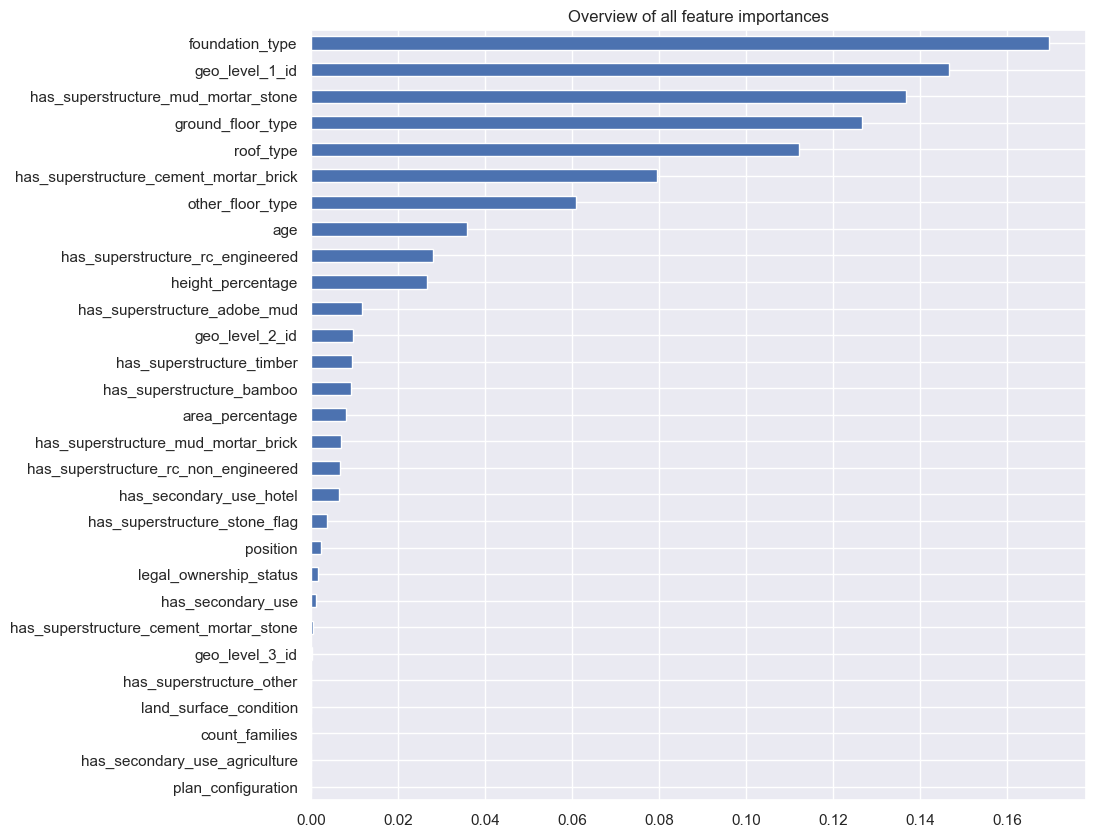

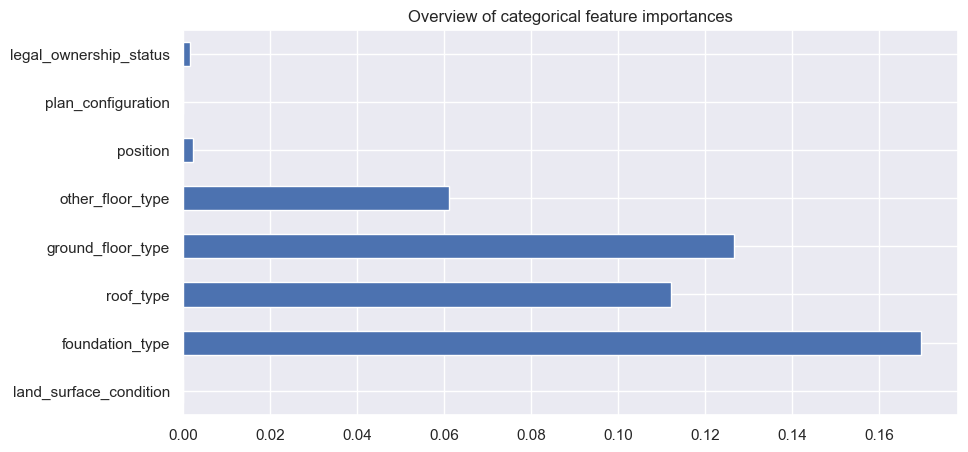

In [62]:
le = TargetEncoder()
__plot_target_encoder_importances(le, X, y)

Again the feature importance for some features increased notably.